In [3]:
from __future__ import division
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import math
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import bisect

H0 = 72.
cosmo = FlatLambdaCDM(H0, Om0=0.3)
h = H0/100

In [4]:
hdulist = fits.open('../petroC_nsa_gzoo.fits')
tbdata = hdulist[1].data
color = tbdata['col10'] #^{0.1}(g-r), K-E corrected to z=0.1, petro
M_r = tbdata['col9'] #^{0.1}(M_r) - 5\log h, K-E corrected to z=0.1, petro
pfeatures = tbdata['t01_smooth_or_features_a02_features_or_disk_weighted_fraction']
psmooth = tbdata['t01_smooth_or_features_a01_smooth_weighted_fraction']
absmag = tbdata['ABSMAG']
absmag_r = absmag[:,4]
HA = tbdata['HAFLUX']
HB = tbdata['HBFLUX']
O3 = tbdata['O3FLUX']
N2 = tbdata['N2FLUX']
D4000 = tbdata['D4000']
z = tbdata['Z']
mass = tbdata['MASS'] #stellar mass from K correction fit, in h^-2 Msun units
hdulist.close()

In [5]:
D4000_bins, SSFR_bins, Errs = np.load('../Dn4000Params_final.npy')

In [6]:
#Magnitude limit calculation
z_lim = 0.06
d = cosmo.luminosity_distance(z_lim).to(u.pc)
m = 17
M_limit = m - 5*math.log(d.value,10) + 5 
print M_limit

-20.0848529966


In [30]:
redpas_pfeatures = []
redpas_psmooth = []
redpas_color = []
redpas_sfr = []
redpas_mr = []

bluact_pfeatures = []
bluact_psmooth = []
bluact_color = []
bluact_sfr = []
bluact_mr = []

redact_pfeatures = []
redact_psmooth = []
redact_color = []
redact_sfr = []
redact_mr = []

all_color = []
all_sfr = []
all_mr = []

FHA_arr = []
FHB_arr = []
FN2_arr = []
FO3_arr = []

HalphaSFR = []
HalphaFlux = []
HbetaFlux = []
HalphaSFR_nodust = []

low_sfr_mass = []
other_mass = []

for i in np.arange(pfeatures.size):
    if z[i] > 0.01 and z[i] < 0.06 and HA[i] > 0 and HB[i] > 0 and O3[i] > 0 and N2[i] > 0: #and absmag_r[i] < M_limit:
        color_line = 0.7 - 0.032*(M_r[i] + 16.5)
        active_line = -10 + 0.094*(M_r[i] + 15)
        
        #Get fluxes in the correct units, add to arrays
        FHA = HA[i]*(1e-17)*u.erg / u.s / u.cm**2
        FHA = FHA.to(u.erg/ u.s / (u.pc**2))
        FHA_arr.append(FHA.value)
        LHA = (cosmo.luminosity_distance(z[i]).to(u.pc)**2) * 4 * math.pi * FHA
        
        FHB = HB[i]*(1e-17)*u.erg / u.s / u.cm**2
        FHB = FHB.to(u.erg/ u.s / (u.pc**2))
        FHB_arr.append(FHB.value)
        LHB = (cosmo.luminosity_distance(z[i]).to(u.pc)**2) * 4 * math.pi * FHB
        
        FO3 = O3[i]*(1e-17)*u.erg / u.s / u.cm**2
        FO3 = FO3.to(u.erg/ u.s / (u.pc**2))
        FO3_arr.append(FO3.value)
        
        FN2 = N2[i]*(1e-17)*u.erg / u.s / u.cm**2
        FN2 = FN2.to(u.erg/ u.s / (u.pc**2))
        FN2_arr.append(FN2.value)
        
        O3_BPT = math.log(FO3/FHB,10)
        N2_BPT = math.log(FN2/FHA,10)
        if O3_BPT > 0.61/(N2_BPT - 0.05) + 1.3 or N2_BPT > -0.2: #galaxies that lie above Kauffman BPT line
            sfr_ind = bisect.bisect_left(D4000_bins, D4000[i])-1 #using bins to calculate SFR
            logSSFR = SSFR_bins[sfr_ind]
        else:
            LHA_c = LHA.value*(((LHA.value/LHB.value)/2.8)**2.36) #corrected HA luminosity from Spindler et. al. 2017
            SFR = LHA_c/(10**41.1)   #SFR calculuted using Halpha flux from Spindler et al 2017
            stell_mass = mass[i]*(h**2)
            logSSFR = math.log(SFR/stell_mass, 10)
            HalphaSFR.append(logSSFR)
            HalphaFlux.append(FHA.value)
            HbetaFlux.append(FHB.value)
            
            SFR_nodust = LHA.value/(10**41.1)
            logSSFR_nodust = math.log(SFR_nodust/stell_mass, 10)
            HalphaSFR_nodust.append(logSSFR_nodust)
            if logSSFR < -12:
                low_sfr_mass.append(stell_mass)
            else:
                other_mass.append(stell_mass)
        all_sfr.append(logSSFR)
        all_color.append(color[i])
        all_mr.append(M_r[i])
        if color[i] >= color_line: #red galaxies
            if logSSFR <= active_line: #passive galaxies - redpas type
                #redpas_pfeatures.append(pfeatures[i])
                #redpas_psmooth.append(psmooth[i])
                redpas_color.append(color[i])
                redpas_sfr.append(logSSFR)
                redpas_mr.append(M_r[i])
            else: #red and active - redact type
                #redact_pfeatures.append(pfeatures[i])
                #redact_psmooth.append(pfeatures[i])
                redact_color.append(color[i])
                redact_sfr.append(logSSFR)
                redact_mr.append(M_r[i])
        if logSSFR >= active_line and color[i] < color_line: #blue and active - bluact type
            #bluact_pfeatures.append(pfeatures[i])
            #bluact_psmooth.append(psmooth[i])
            bluact_color.append(color[i])
            bluact_sfr.append(logSSFR)
            bluact_mr.append(M_r[i])
        elif logSSFR <= active_line and color[i] > color_line: 
            blupas += 1

In [31]:
print np.mean(np.array(low_sfr_mass))
print len(low_sfr_mass)
print np.mean(np.array(other_mass))

13627871062.6
1209
3037725031.75


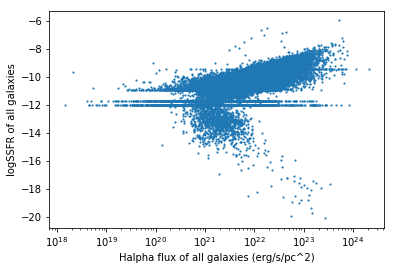

In [23]:
plot = plt.figure()
plt.scatter(FHB_arr, all_sfr, marker = '.', s=5)
#plt.xlim(-1.5,0.5)
#plt.ylim(-1.2,1.5)
plt.xscale('log')
plt.ylabel('logSSFR of all galaxies')
plt.xlabel('Halpha flux of all galaxies (erg/s/pc^2)')
plt.show()

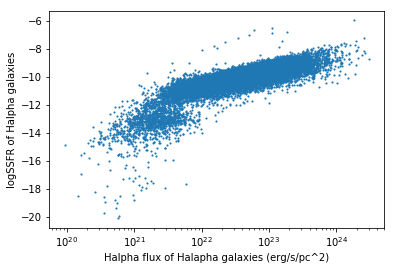

In [24]:
plot2 = plt.figure()
plt.scatter(HalphaFlux, HalphaSFR, marker = '.', s=5) #this only plots galaxies which have their SFR calculated with Halpha
#plt.xlim(-1.5,0.5)
#plt.ylim(-1.2,1.5)
plt.xscale('log')
plt.ylabel('logSSFR of Halpha galaxies')
plt.xlabel('Halpha flux of Halapha galaxies (erg/s/pc^2)')
plt.show()

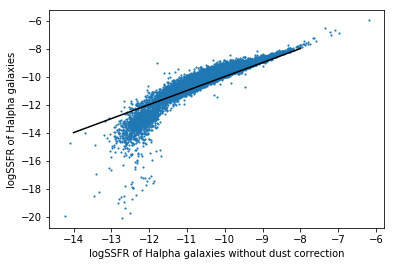

In [25]:
plot3 = plt.figure()
plt.scatter(HalphaSFR_nodust, HalphaSFR, marker = '.', s=5) #this only plots galaxies which have their SFR calculated with Halpha
#plt.xlim(-1.5,0.5)
#plt.ylim(-1.2,1.5)
plt.ylabel('logSSFR of Halpha galaxies')
plt.xlabel('logSSFR of Halpha galaxies without dust correction')
plt.plot([-14,-13,-12,-10,-8],[-14,-13,-12,-10,-8], c='k')
plt.show()

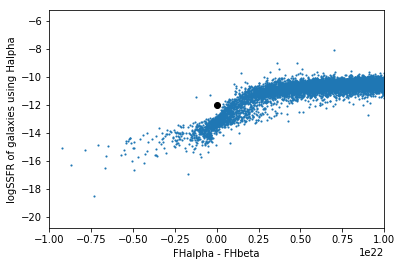

In [26]:
plot4 = plt.figure()
diff = np.array(HalphaFlux) - np.array(HbetaFlux)
plt.scatter(diff, HalphaSFR, marker = '.', s=5) #this only plots galaxies which have their SFR calculated with Halpha
plt.xlim(-0.1e23,0.1e23)
plt.scatter(0,-12, c='k')
#plt.ylim(-1.2,1.5)
plt.ylabel('logSSFR of galaxies using Halpha')
plt.xlabel('FHalpha - FHbeta')
plt.show()

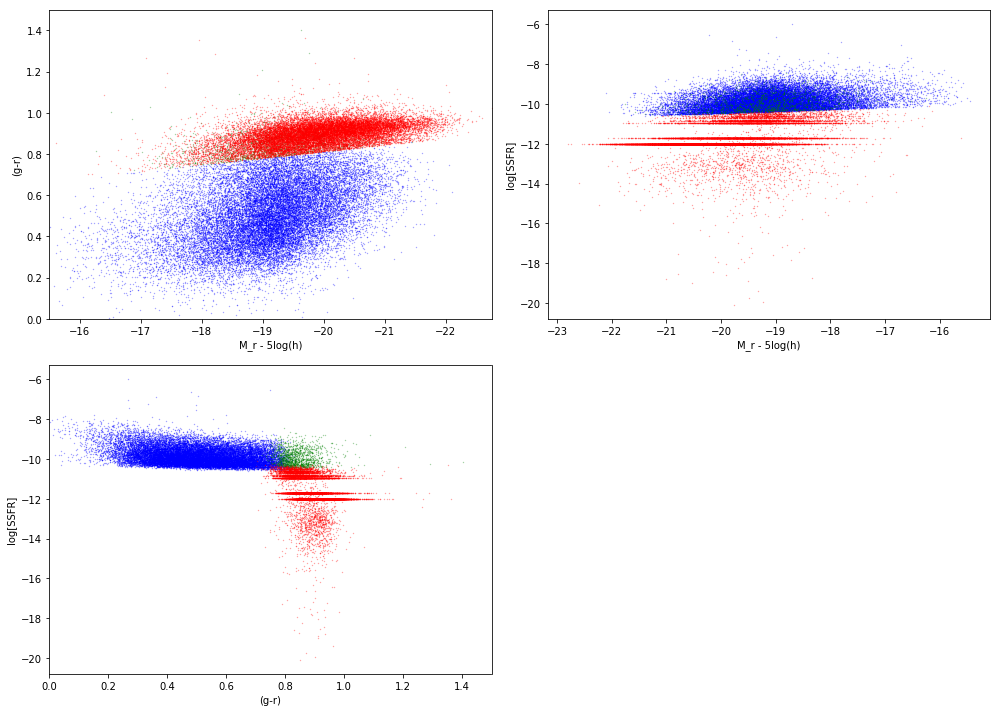

In [27]:
fig = plt.figure(figsize=(14,10))

colors = [bluact_color, redact_color, redpas_color]
mrs = [bluact_mr, redact_mr, redpas_mr]
sfrs = [bluact_sfr, redact_sfr, redpas_sfr]
plot_color = ['b', 'g', 'r']

#top left plot
ax1 = fig.add_subplot(221)
#ax1.scatter(all_mr, all_color,s=.1)
for i in np.arange(3):
    ax1.scatter(mrs[i], colors[i], color = plot_color[i], s=0.1, alpha=0.5)

ax1.set_ylabel('(g-r)')
ax1.set_xlabel('M_r - 5log(h)')
ax1.set_ylim(0, 1.5)
ax1.set_xlim(-15.5, -22.75)

#top right plot
ax2 = fig.add_subplot(222)
for i in np.arange(3):
    ax2.scatter(mrs[i], sfrs[i], color = plot_color[i], s=0.1, alpha=0.5)
#ax2.scatter(all_mr, all_sfr, s=.1)
ax2.set_ylabel('log[SSFR]')
ax2.set_xlabel('M_r - 5log(h)')
#ax2.set_ylim(-14, -8.5)
#ax2.set_xlim(-15.5, -22.75)

#bottom left plot
ax3 = fig.add_subplot(223)
for i in np.arange(3):
    ax3.scatter(colors[i], sfrs[i], color = plot_color[i], s=0.1, alpha=0.5)
#ax3.scatter(all_color, all_sfr, s=.1)
ax3.set_ylabel('log[SSFR]')
ax3.set_xlabel('(g-r)')
#ax3.set_ylim(-14, -8.5)
ax3.set_xlim(0,1.5)

plt.tight_layout()
plt.show()

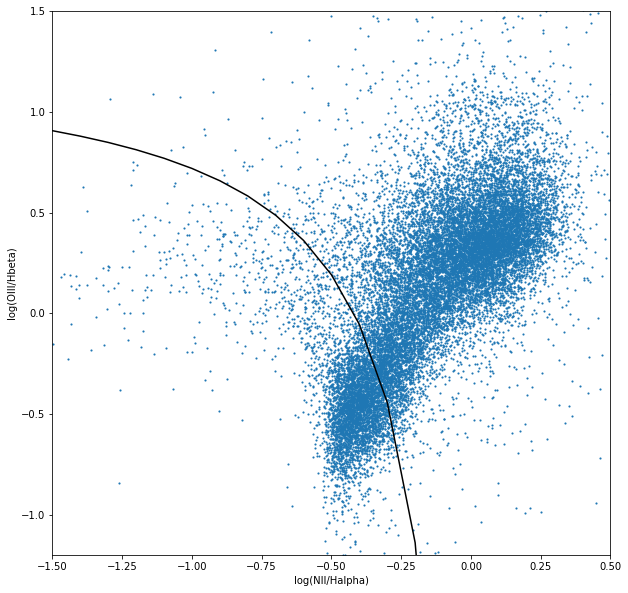

In [13]:
fig2 = plt.figure(figsize=(10,10))

O3HB = []
N2HA = []
for i in np.arange(len(FO3_arr)):
    if FO3_arr[i] > 0 and FHB_arr[i] > 0 and FN2_arr[i] > 0 and FHA_arr[i] > 0:
        O3HB.append(math.log(FO3_arr[i]/FHB_arr[i], 10))
        N2HA.append(math.log(FN2_arr[i]/FHA_arr[i], 10))

#create Kauffman line:
KN2 = np.arange(-1.5,0,0.1)
KO3 = 0.61/(KN2-0.05) + 1.3
plt.plot(KN2, KO3, color='k')
plt.scatter(N2HA, O3HB, marker = '.', s=5)
#plt.scatter(HalphaSFR, np.arange(len(HalphaSFR)))
plt.xlim(-1.5,0.5)
plt.ylim(-1.2,1.5)
#plt.xlim(-3,1)
#plt.ylim(-3,2)
plt.xlabel('log(NII/Halpha)')
plt.ylabel('log(OIII/Hbeta)')
plt.show()
#plt.savefig('../BPT.jpg')

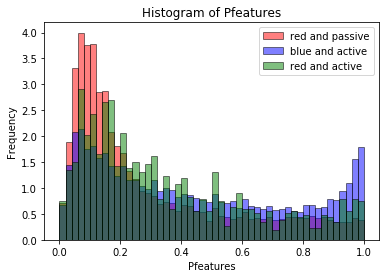

In [60]:
plt.hist(redpas_pfeatures, 50, normed=1, facecolor='r', alpha=0.5, ec='black', label='red and passive')
plt.hist(bluact_pfeatures, 50, normed=1, facecolor='b', alpha=0.5, ec='black', label='blue and active')
plt.hist(redact_pfeatures, 50, normed=1, facecolor='g', alpha=0.5, ec='black', label='red and active')
plt.xlabel('Pfeatures')
plt.ylabel('Frequency')
plt.title('Histogram of Pfeatures')
plt.legend(loc='upper right')
plt.show()

/home/jotter/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6201: RuntimeWarning: invalid value encountered in true_divide
  m = (m.astype(float) / db) / m.sum()


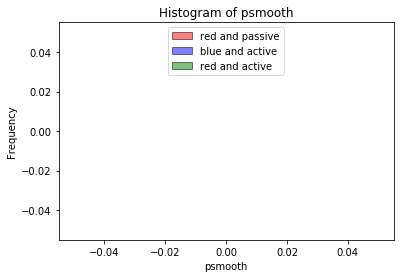

In [38]:
plt.hist(redpas_psmooth, 50, normed=1, facecolor='r', alpha=0.5, ec='black', label='red and passive')
plt.hist(bluact_psmooth, 50, normed=1, facecolor='b', alpha=0.5, ec='black', label='blue and active')
plt.hist(redact_psmooth, 50, normed=1, facecolor='g', alpha=0.5, ec='black', label='red and active')
plt.xlabel('psmooth')
plt.ylabel('Frequency')
plt.title('Histogram of psmooth')
plt.legend(loc='upper center')
plt.show()